# ENGG*3130 Final Project
**By: Spencer Ploeger<br>
0969141<br>
sploeger@uoguelph.ca<br>
Lucas Dasovic<br>
0069420<br>
ldasovic@uoguelph.ca**


## Background: 1.1 Detectctron2

Detectron2 is a framework that allows for the implementation of various computer vision networks.

Here is the sample video we will run detectron2 on:<br>(Note that the video is also located in /sample_videos/ )

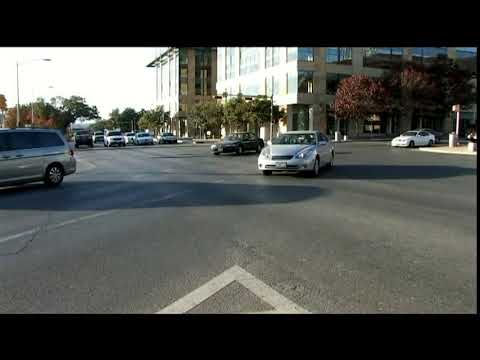

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('-rSyFxLjdZ4')

**Run detectron2 on a sample video.**
Note that the sample video is localed in ./sample_videos/. You can run on any video you'd like. Just update the above directory and video name. Note: The video input must be an mp4!.

In [2]:
video_name = 'driveby.mp4'
video_path = './sample_videos/'
model_path = './models/model_final_9243eb.pkl'
config_path = './configs/COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml'

Import dependancies for Detectron2:

In [3]:
from multiprocessing import Queue
import logging
import cv2
import subprocess as sp
import sys
import argparse
import image2pipe
from PIL import Image
from IPython.display import Video
from IPython.display import HTML
import ipdb
import numpy as np
import torch
import io
import random
import glob
import os
import tqdm
from matplotlib import pyplot as plt
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data.detection_utils import read_image
from detectron2.modeling import build_model

In [4]:
#make sure if a GPU is available, it will be used by torch rather than the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
cfg = get_cfg()
cfg.merge_from_file(config_path) #load the desired model (in local directory)
#cfg.merge_from_file("./configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml") #load the desired model (in local directory)
#cfg.merge_from_file("../configs/COCO-Detection/faster_rcnn_R_50_C4_3x.yaml") #load the desired model (in local directory)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set threshold for this model

metadata = MetadataCatalog.get(
    cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
)
#cpu_device = torch.device("cpu")
instance_mode = ColorMode.IMAGE

model = build_model(cfg) # returns a torch.nn.Module
DetectionCheckpointer(model).load(model_path) # must load weights this way (in local directory)
#DetectionCheckpointer(model).load('./models/keypoint_rcnn_r50_3x/model_final_a6e10b.pkl') # must load weights this way
#DetectionCheckpointer(model).load('../models/faster_rcnn_r50_c4/model_final_f97cb7.pkl') # must load weights this way (in local directory)
model.train(False) # inference mode

GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
      (1): BottleneckBlock(

In [6]:
torch.cuda.empty_cache()

In [7]:
def get_info(vid_name):
    #get the height and width of the video
    out = sp.Popen(["ffprobe", "-v", "error", "-select_streams", "v:0", "-show_entries", "stream=width,height", "-of", "csv=p=0", vid_name],stdout=sp.PIPE,stderr=sp.STDOUT)
    stdout,stderr = out.communicate()
    output = stdout.decode("utf-")
    #split height and width
    height = output.split(',')[1]
    width = int(output.split(',')[0])
    height = int(height[:-1])

    #get the framerate of the video
    out = sp.Popen(["ffprobe", "-v", "error", "-select_streams", "v", "-of", "default=noprint_wrappers=1:nokey=1", "-show_entries", "stream=r_frame_rate", vid_name],stdout=sp.PIPE,stderr=sp.STDOUT)
    stdout,stderr = out.communicate()
    output = stdout.decode("utf-")
    numerator = int(output.split('/')[0])
    denominator = int(output.split('/')[1])
    framerate =  round(numerator/denominator)

    out = sp.Popen(["ffprobe", "-v", "error", "-select_streams", "v:0", "-show_entries", "stream=nb_frames", "-of", "csv=p=0", vid_name],stdout=sp.PIPE,stderr=sp.STDOUT)
    stdout,stderr = out.communicate()
    output = stdout.decode("utf-")
    total_frames = int(output[:-1])


    #print video information
    print("Height: ", height)
    print("Width: ", width)
    print("Framerate: ", framerate)
    print("Total Frames: ", total_frames)

    return height, width, framerate, total_frames

In [8]:
#we must resize the image tensor to be consistent with the flownet inference sizes
def get_image_tensor(image):
    #read in one image
    img_original = image
    height = img_original.shape[0]
    width = img_original.shape[1]
    #img_orignal = read_image("./img1.jpg", format="BGR")
    img = cv2.resize(img_original, dsize = (height,width), interpolation=cv2.INTER_CUBIC) #check this and compare with demo
    img = np.transpose(img,(2,0,1))
    img_tensor = torch.from_numpy(img)
    #print("tensor size:", img_tensor.size())
    return img_tensor

In [9]:
path = video_path+video_name
print(path)
height, width, framerate, num_frames = get_info(path)
q = Queue()
decoder = image2pipe.images_from_url(q, path, fps=framerate, pix_fmt='rgb24', scale=(width, height))
decoder.start()

./sample_videos/driveby.mp4
Height:  720
Width:  1280
Framerate:  30
Total Frames:  260


 12%|█▏        | 31/260 [00:57<07:01,  1.84s/it]


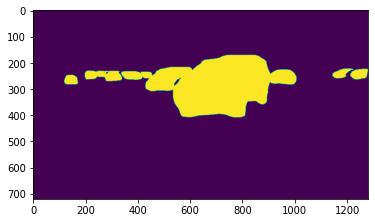

In [10]:
for x in tqdm.trange(num_frames):
    try:
        fn, img = q.get()
        #print(fn)
        #print(img.shape)
        image = Image.fromarray(img, 'RGB')
        open_cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        #img_orignal = cv2.imread(open_cv_image)
        frame_tensor = get_image_tensor(open_cv_image)

        x = [{"image" : frame_tensor, "height": height, "width": width}] * 1
        #get predictions from the model
        predictions = model(x)

        #print the predictions
        bin_mask = predictions[0]['instances'].pred_masks
        #print(bin_mask)
        #print(bin_mask.shape)
        bin_mask_np = bin_mask.cuda().detach().cpu().clone().numpy()
        #print(bin_mask_np.shape)
        num_classes = bin_mask_np.shape[0]
        #print("num classes: ", num_classes)

        a = np.zeros((height, width), dtype=bool)


        for i in range(num_classes): #for all the classes detected
            x = bin_mask_np[i,:,:] #x is the ith class
            new_mask = np.ma.mask_or(a, x) #logic or the current classes pixels with the other classes pixels
            a = new_mask #update the new mask

        #plt.imshow(a)
        #plt.show()
        del predictions
        torch.cuda.empty_cache()
        name = "temp_" + str(fn) + ".png"
        plt.imshow(a)
        plt.savefig(name)
        #ipdb.set_trace()#create a breakpoint
        if(fn>30): #stop after 30 frames
            break
    except TypeError as e:
        print("The error: ")
        print(e)
        print("End of frames")
        break

Once detectron runs predictions on each frame, we can view one of these frames.<br>**Note:** we will be taking the masks genereated by detectron2 and visualizing them as a binary mask. This lets us see all the objects detected as a single layer, which makes qualitiative observations about consistencey easier.

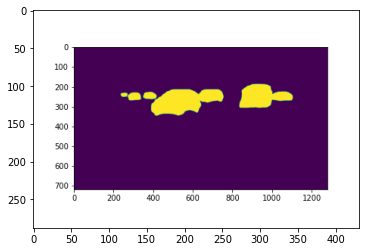

In [11]:
img = plt.imread('temp_2.png')
plt.imshow(img)
plt.show()

Let's stich many of these frames together to make a video. We will use ffmpeg to do this.

In [46]:
#create the output video with ffmpeg
output_name = '1.1_detectron2_output.mp4'
out = sp.run(["ffmpeg", "-y", "-i", "temp_%d.png", "-vcodec", "mpeg4", output_name])

#now delete the temp frames
#delete the temp .png files
fileList = glob.glob('temp_*.png')
#Iterate over the list of filepaths & remove each file.
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

Now we can view the video:
Note, there seems to be some problem with the video player. If the video does not play, you can download the video from /engg3130-project/ and then view it on your computer.

<video controls src=output_name />

As we can tell, the video is very choppy and full of artifacts. These artifacts are undesireable. They are a result of detectron2 not having any notion of motion or relation of objects between any two frames. We need a way to address and fix this.

**Note:** For these tests we are using the computer vision framework called "Mask-RCNN". Detectron2 is able to use a multitude of different frameworks. For example, here are some youtube clips of the various videos being run through different models:

**Driving on the 401**<br>Model used: Panoptic FPN R50 1x<br>The common theme remain. There is many instances of artifacting between frames. Objects rapidly appear only to disappear frames later. Take special note of the cars in the far left background, or the fauna on the right side.

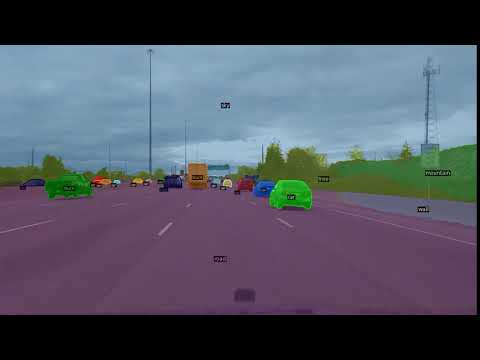

In [13]:
YouTubeVideo('ZBFO1hhdHJ0')

**Walking on the Boarwalk**<br>Model used: Mask R-CNN R50 1x<br>Once again there are many instances of flickering and inconsistent object segmentation between frames. Take particular note of the traffic lights on the right side of the video, or the people and benches on the left.

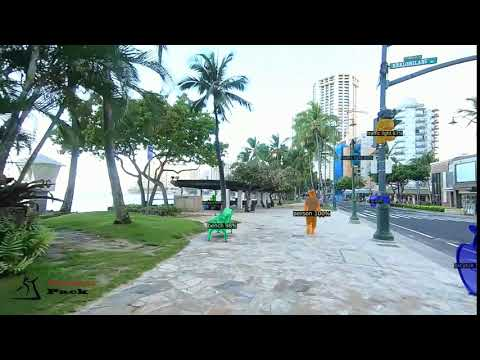

In [14]:
YouTubeVideo('ZYKUq6mMlvI')

## Background: 1.2 FlowNet2

FlowNet2-Pytorch is a pytorch implementation of Optical Flow Estimation using Deep Networks. Essentially it allows for the estimation of a pixels movement from one frame to the next.

This gives us something that Detectron2 does not- a notion of conectiveness between two frames. Lets investigate what kind of output it can give us:

**Note:**
1. The code used to genereate the flownet output is from the repo: https://github.com/dancelogue/flownet2-pytorch
2. For simplicty in this version* of the notebook, the flownet output files have been *previously generated* for the first 30 frames of three seperate videos. The model **FlowNet2** was used to generate the flow data.
3. The flownet .flo files for these three video are located in /flow_data/
4. The three videos are: driveby.mp4, walking.mp4, and driving_on_the_401.mp4

<br>*This will be changed in the next update of this notebook.

Let's pick the same video as earlier (driveby.mp4), and take a look at the .flo files that flownet generates:

In [15]:
#function that parses the raw data from a flow file
TAG_FLOAT = 202021.25
flags = {
    'debug': False
}
def read_flow(path):
    if not isinstance(path, io.BufferedReader):
        if not isinstance(path, str):
            raise AssertionError(
                "Input [{p}] is not a string".format(p=path))
        if not os.path.isfile(path):
            raise AssertionError(
                "Path [{p}] does not exist".format(p=path))
        if not path.split('.')[-1] == 'flo':
            raise AssertionError(
                "File extension [flo] required, [{f}] given".format(f=path.split('.')[-1]))

        flo = open(path, 'rb')
    else:
        flo = path

    tag = np.frombuffer(flo.read(4), np.float32, count=1)[0]
    if not TAG_FLOAT == tag:
        raise AssertionError("Wrong Tag [{t}]".format(t=tag))

    width = np.frombuffer(flo.read(4), np.int32, count=1)[0]
    if not (width > 0 and width < 100000):
        raise AssertionError("Illegal width [{w}]".format(w=width))

    height = np.frombuffer(flo.read(4), np.int32, count=1)[0]
    if not (width > 0 and width < 100000):
        raise AssertionError("Illegal height [{h}]".format(h=height))

    nbands = 2
    tmp = np.frombuffer(flo.read(nbands * width * height * 4),
                        np.float32, count=nbands * width * height)
    flow = np.resize(tmp, (int(height), int(width), int(nbands)))
    flo.close()

    return flow

flow_to_mask function
This funtion takes in one flow file (.flo) and returns a mask, tensor, and height, width, and the raw flow data
paramaters:
- flow file (the path to a .flo file)
- threshold (OPTIONAL, threshold of pixel movement magnitude used to generate flow mask. Defaults to 0.5)

returns:
- flow (HxWx2 Numpy array)
- flow_tensor (HxWx2 Tensor)
- flow_mask (A mask generated from flow using passed in magnitude)
- height (height of the flow mask)
- width (width of the flow mask)

In [16]:
#function to convert flow data to mask
#returns the mask, the height, and the width
def flow_to_mask(flo_file, threshold=0.5):
    flow = read_flow(flo_file)
    height = flow.shape[0]
    width = flow.shape[1]
    u = flow[:,:,0]
    v = flow[:,:,1]
    x = np.sqrt(u**2 + v**2)
    flow_mask = x>threshold
    flow_tensor = torch.from_numpy(flow)
    return flow, flow_tensor, flow_mask, height, width

Pick a directory (in this case, for the driveby video), and a frame to view (in this case, frame 0)

In [17]:
flow_folder = "./flow_data/driveby/"
flow_file = "000000.flo"

In [18]:
path = flow_folder+flow_file
print(path)
flow, flow_tensor, flow_mask, height, width = flow_to_mask(path)

./flow_data/driveby/000000.flo


The output from the function call:

In [19]:
print("Shape of the flow file is: ",flow.shape)
print("Shape of the mask is: ", flow_mask.shape)
print("Height of the flow file is: ", height)
print("Width of the flow file is: ", width)
print("Tensor size: ",flow_tensor.shape)

Shape of the flow file is:  (704, 1280, 2)
Shape of the mask is:  (704, 1280)
Height of the flow file is:  704
Width of the flow file is:  1280
Tensor size:  torch.Size([704, 1280, 2])


From above we can notice a few things.

First, the height of the flow tensor and mask are not the same as the video. This is becasue flownet automatically crops all images to heights and widths that are multiples of 64. This is so when Tensors are batched and then concatenated, they all have the same dimensions.

Second, the tensor and flow array both have a new third dimnsion. Let's inspect it.

In [20]:
#pick the pixel at 300,500 (y,x)
this_pixel = flow_tensor[300,500] #y, x!!
print(this_pixel)

tensor([-13.5089,   1.8003])


We notice that for each pixel, there are two vectors, call them U and V. They represent the x and y motion of that pixel respectively, on a traditional cartesian plane.

To visualize this movement, we can use a scale like the one below. 

Therefore, for the above pixel with magnitude for U and V of -13.5080, 1.8003, we expect a vector to the left and slightly up. Accoring to the scale below, this would correspond to a blue/turqoise color.

Note that these scales are relative to other pixels in the frame. The only constraint on movement vectors U and V is that they must be of magnitude < 1E9.

[1]

![title](./notebook_supporting/scale.png)

References


-  [1] https://towardsdatascience.com/generating-optical-flow-using-nvidia-flownet2-pytorch-implementation-d7b0ae6f8320

We can take a look at the visualized flow file for this image. Like the flow data, the image was generated previously using the flow2image library(https://github.com/skeeet/flow2image):

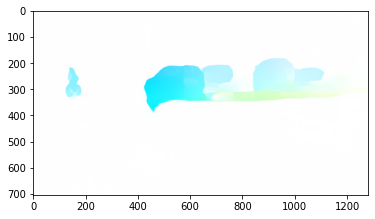

In [21]:
path_to_image = "./flow_data/driveby/images/"
image = flow_file+".png"
img = plt.imread(path_to_image+image)
plt.imshow(img)
plt.show()

This is the video generated by FlowNet2 when applied to the driveby video. As mentioned earlier, it was prviously generated using an external repo:

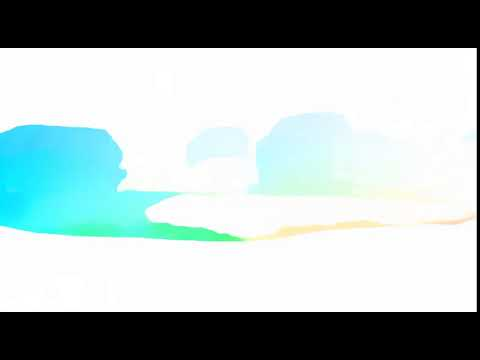

In [22]:
YouTubeVideo("JLM5r_O_x6I")

Now, lets see the mask returned by the flow_to_image function. It was generated using a movement threhsold paramter of 0.5. Ie: sqrt(U^2 + V^2)>0.5.

We get the following image:

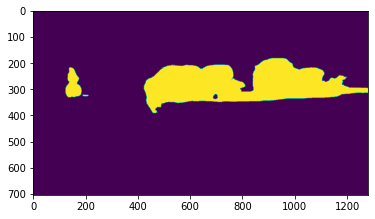

In [23]:
plt.imshow(flow_mask)

This mask is pretty crucial. It shows us that is moving and what is stationary in the frame. Anything above a movement magnitude of 0.5 is shown in yellow, and anything below this threshold is shown in purple. **We now have a way to guage motion based off of data from other frames. In other words, we no longer only have a single frame's data at our disposal.**

## 2 - Combining the two networks

Detectron2 gives us a very good way to segment objects accurately, but does not carry predictions well between frames of video. This is due to the nature of how Detectron2 is trained. It is trained on single frames, and this is how it treats video- one single frame at a time.

Flownet2 on the other hand, is specifically designed to make movement predictions on consecutive frames. This is how it was trained and this is why it is so good at predicitng movement in video. However, it has no way to segment objects or instances as Detectron2 can.

**We will attempt to combine aspects of both networks. If we can find some way to determine when a detection network makes incorrect predictions in a frame, we can generate a loss function. This loss function can be used to train a neural network. The hope is that the network can be trained to make better predictions on videos, with improved frame-to-frame consistceny.**

First, some supporting functions for later. They have been adapted from [Thor](https://github.com/ThorJonsson). Thank you Thor.

In [24]:
#preds and gt same size
def binary_dice(preds, gt,mask=None):
    res = {}
    one = torch.ones(preds.size()).to(preds.device)
    if mask is None:
        mask = one
   
    tp = (mask*(preds*gt)).sum() #where GT and preds both 1
    fp = (mask*(preds*(~gt))).sum() #where pred is 1 but gt 0
    fn = (mask*((~preds)*gt)).sum()
    tn = (mask*((~preds)*(~gt))).sum()
    res['acc'] = ((tp + tn)/(tp + fp + tn + fn)).item()
    if tp + fn == 0:
        res['recall'] = (tp + fn).item()
    else:
        res['recall'] = (tp/(tp + fn)).item()
    if tp + fp == 0:
        res['prec'] = (tp + fp).item()
    else:
        res['prec'] = (tp/(tp + fp)).item()
    if tp + fp + fn == 0:
        res['f1'] = (tp + fp + fn).item()
        iou = tp + fp + fn
    else:
        res['f1'] = ((2*tp)/(2*tp + fp + fn)).item()
        iou = tp/(tp + fp + fn)
    loss = 1 - iou
    res['dice'] = loss.item()
   
    return loss, res

In [25]:
def dice_loss(seg_mask, flow_mask):
    """
    ***
    Calculates the dice loss.
    n - num videos (batch size) (always 1 for now)
    t - # frames total
    height
    width
    num_instances - how many instances in the given frame
    ***
    seg_mask is a binary tensor of shape [t,height,width]
    flow_mask is a tensor of shape [t,height,width]
    """
    # permute predictions to make class channels be last
    #preds = f.softmax(preds.permute(0, 2, 3, 4, 1), dim=-1)
    #preds = discretize(preds)
    #num_inst = seg_mask.shape[-1] #last 
    num_frames = seg_mask.shape[0] #last 
    res = {}
    loss = 0
    for i in range(num_frames):
        x = seg_mask[i, :, :]
        y = flow_mask[i, :, :]
        loss_i, res_i = binary_dice(x, y)
        for key, value in res_i.items():
            res[key + f'_{i}'] = value
        loss += loss_i
    return loss/num_frames, res

We will re-run the Mask-RCNN network with Detectron2 on the video ```driveby.mp4```. The reason for this is because earlier we were using the video's native resolution to generate our output. As mentioned earlier, FlowNet2 re-sizes input videos so the height and width must be divisible by 64. We will re-run Detectron2 using this new resolution of 704x1080 to make the masks match the size of the flownet output

In [26]:
#Check the resolution of the .flo files
flow_folder = "./flow_data/driveby/"
flow_file = "000000.flo"
path = flow_folder+flow_file
print(path)
flow, flow_tensor, flow_mask, height, width = flow_to_mask(path)
print("new_height: ", height)
print("new_width: ", width)

./flow_data/driveby/000000.flo
new_height:  704
new_width:  1280


Set this new height and width to later use when running Detectron2 again.

Now we will run Detectron2 on the driveby.mp4 video again, but with the new width and height. **Note: we will stop Detectron2 from running after it has proccessed 30 frames. This is done to save time** We will also remove the step of exporting images and creating an output video as we are only concerned with the output masks in this stage.

In [27]:
video_name = 'driveby.mp4'
video_path = './sample_videos/'
model_path = './models/model_final_9243eb.pkl'
config_path = './configs/COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml'

In [28]:
cfg = get_cfg()
cfg.merge_from_file(config_path) #load the desired model (in local directory)
#cfg.merge_from_file("./configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml") #load the desired model (in local directory)
#cfg.merge_from_file("../configs/COCO-Detection/faster_rcnn_R_50_C4_3x.yaml") #load the desired model (in local directory)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set threshold for this model

metadata = MetadataCatalog.get(
    cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
)
#cpu_device = torch.device("cpu")
instance_mode = ColorMode.IMAGE

model = build_model(cfg) # returns a torch.nn.Module
DetectionCheckpointer(model).load(model_path) # must load weights this way (in local directory)
#DetectionCheckpointer(model).load('./models/keypoint_rcnn_r50_3x/model_final_a6e10b.pkl') # must load weights this way
#DetectionCheckpointer(model).load('../models/faster_rcnn_r50_c4/model_final_f97cb7.pkl') # must load weights this way (in local directory)
model.train(False) # inference mode

GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
      (1): BottleneckBlock(

In [29]:
torch.cuda.empty_cache()

In [30]:
path = video_path+video_name
print(path)
vid_height, vid_width, framerate, num_frames = get_info(path)
q = Queue()
decoder = image2pipe.images_from_url(q, path, fps=framerate, pix_fmt='rgb24', scale=(width, height))
decoder.start()

./sample_videos/driveby.mp4
Height:  720
Width:  1280
Framerate:  30
Total Frames:  260


In [31]:
#Create an empty list to store a tensor for each video frame
detectron_tensors = []
detectron_frames = []

In [32]:
for x in tqdm.trange(num_frames):
    try:
        fn, img = q.get()
        print(fn)
        #print(img.shape)
        image = Image.fromarray(img, 'RGB')
        open_cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        #img_orignal = cv2.imread(open_cv_image)
        frame_tensor = get_image_tensor(open_cv_image)

        x = [{"image" : frame_tensor, "height": 704, "width": 1280}] * 1
        #get predictions from the model
        predictions = model(x)
        #print the predictions
        bin_mask = predictions[0]['instances'].pred_masks
        #print(bin_mask)
        print(bin_mask.shape) #bin mask is a tensor of shape t,h,w
        #print(det_tensor.type())
        #print(bin_mask.type())
        #det_tensor = torch.stack((det_tensor, bin_mask))
        detectron_tensors.append(bin_mask)
        bin_mask_np = bin_mask.cuda().detach().cpu().clone().numpy()
        #print(bin_mask_np.shape)
        num_classes = bin_mask_np.shape[0]
        #print("num classes: ", num_classes)
        
        #add the frame mask to the list of masks
        detectron_frames.append(bin_mask_np)

        a = np.zeros((704, 1280), dtype=bool)


        for i in range(num_classes): #for all the classes detected
            x = bin_mask_np[i,:,:] #x is the ith class
            new_mask = np.ma.mask_or(a, x) #logic or the current classes pixels with the other classes pixels
            a = new_mask #update the new mask

        #plt.imshow(a)
        #plt.show()
        del predictions
        torch.cuda.empty_cache()
        name = "temp_" + str(fn) + ".png"
        #plt.imshow(a)
        plt.savefig(name)
        #ipdb.set_trace()#create a breakpoint
        if(fn>30): #stop after 30 frames
            break
    except TypeError as e:
        print("The error: ")
        print(e)
        print("End of frames")
        break

  0%|          | 0/260 [00:00<?, ?it/s]

0


  0%|          | 1/260 [00:00<02:34,  1.68it/s]

torch.Size([7, 704, 1280])
1


  1%|          | 2/260 [00:01<02:24,  1.78it/s]

torch.Size([6, 704, 1280])
2


  1%|          | 3/260 [00:01<02:19,  1.84it/s]

torch.Size([7, 704, 1280])
3


  2%|▏         | 4/260 [00:02<02:19,  1.84it/s]

torch.Size([8, 704, 1280])
4


  2%|▏         | 5/260 [00:02<02:20,  1.82it/s]

torch.Size([8, 704, 1280])
5


  2%|▏         | 6/260 [00:03<02:20,  1.81it/s]

torch.Size([10, 704, 1280])
6


  3%|▎         | 7/260 [00:03<02:20,  1.81it/s]

torch.Size([9, 704, 1280])
7


  3%|▎         | 8/260 [00:04<02:19,  1.81it/s]

torch.Size([8, 704, 1280])
8


  3%|▎         | 9/260 [00:04<02:16,  1.84it/s]

torch.Size([8, 704, 1280])
9


  4%|▍         | 10/260 [00:05<02:13,  1.87it/s]

torch.Size([8, 704, 1280])
10


  4%|▍         | 11/260 [00:05<02:11,  1.89it/s]

torch.Size([8, 704, 1280])
11


  5%|▍         | 12/260 [00:06<02:10,  1.90it/s]

torch.Size([11, 704, 1280])
12


  5%|▌         | 13/260 [00:06<02:08,  1.92it/s]

torch.Size([7, 704, 1280])
13


  5%|▌         | 14/260 [00:07<02:05,  1.96it/s]

torch.Size([7, 704, 1280])
14


  6%|▌         | 15/260 [00:07<02:01,  2.01it/s]

torch.Size([7, 704, 1280])
15


  6%|▌         | 16/260 [00:08<01:58,  2.06it/s]

torch.Size([6, 704, 1280])
16


  7%|▋         | 17/260 [00:08<01:55,  2.10it/s]

torch.Size([5, 704, 1280])
17


  7%|▋         | 18/260 [00:09<01:54,  2.12it/s]

torch.Size([6, 704, 1280])
18


  7%|▋         | 19/260 [00:09<01:55,  2.10it/s]

torch.Size([7, 704, 1280])
19


  8%|▊         | 20/260 [00:10<01:51,  2.15it/s]

torch.Size([7, 704, 1280])
20


  8%|▊         | 21/260 [00:10<01:49,  2.18it/s]

torch.Size([8, 704, 1280])
21


  8%|▊         | 22/260 [00:11<01:50,  2.16it/s]

torch.Size([8, 704, 1280])
22


  9%|▉         | 23/260 [00:11<01:49,  2.17it/s]

torch.Size([9, 704, 1280])
23


  9%|▉         | 24/260 [00:12<01:49,  2.16it/s]

torch.Size([8, 704, 1280])
24


 10%|▉         | 25/260 [00:12<01:49,  2.14it/s]

torch.Size([10, 704, 1280])
25


 10%|█         | 26/260 [00:12<01:51,  2.10it/s]

torch.Size([9, 704, 1280])
26


 10%|█         | 27/260 [00:13<01:54,  2.03it/s]

torch.Size([12, 704, 1280])
27


 11%|█         | 28/260 [00:13<01:52,  2.07it/s]

torch.Size([10, 704, 1280])
28


 11%|█         | 29/260 [00:14<01:52,  2.06it/s]

torch.Size([11, 704, 1280])
29


 12%|█▏        | 30/260 [00:14<01:52,  2.05it/s]

torch.Size([11, 704, 1280])
30


 12%|█▏        | 31/260 [00:15<01:51,  2.06it/s]

torch.Size([11, 704, 1280])
31


 12%|█▏        | 31/260 [00:15<01:57,  1.94it/s]

torch.Size([12, 704, 1280])


<Figure size 432x288 with 0 Axes>

Create a Tensor that holds the overall segmentation mask of the first 30 video frames.

Also create a list that holds each frames segmentation mask as a numpy array.

In [33]:
flow_image_list = sorted(glob.glob('./flow_data/driveby/images/*.png'))

In [34]:
#ensure GPU is set as device if it available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detectron_combined_frames = []
to_combine = [] #temp list of frame seg mask tensors that will later be stacked

for a in range(len(flow_image_list)):
    current_frame = detectron_frames[a]
    num_classes = current_frame.shape[0]
    seg_mask = np.zeros((height, width), dtype=bool)
    for b in range(num_classes):
        b = current_frame[b,:,:] #x is the ith class
        new_mask = np.ma.mask_or(seg_mask, b) #logic or the current classes pixels with the other classes pixels
        seg_mask = new_mask #update the new mask
    #plt.imshow(seg_mask)
    detectron_combined_frames.append(seg_mask)
    seg_tensor = torch.from_numpy(seg_mask).to(device)
    to_combine.append(seg_tensor)
seg_frames_tensor = torch.stack(to_combine)

print("Shape of segmentation frames tensor: ",seg_frames_tensor.shape)
print("Length of segmentation mask frames list: ",len(detectron_combined_frames))

Shape of segmentation frames tensor:  torch.Size([30, 704, 1280])
Length of segmentation mask frames list:  30


Lets use the flow data for the same video to create a similar flow frames tensor and flow mask list.

In [35]:
flow_file_list = sorted(glob.glob('./flow_data/driveby/*.flo'))

In [36]:
#ensure GPU is set as device if it available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

flow_combined_frames = [] #a list to hold each frames flow mask
to_combine = [] #temp list of frame flow tensors that will later be stacked

for file in range(len(flow_file_list)):
    flow, flow_tensor, flow_mask, height, width = flow_to_mask(flow_file_list[file])
    flow_combined_frames.append(flow_mask)
    to_combine.append(torch.from_numpy(flow_mask).to(device))
    
flow_frames_tensor = torch.stack(to_combine)

print("Shape of flow frames tensor: ",flow_frames_tensor.shape)
print("Length of flow mask frames list: ",len(flow_combined_frames))

Shape of flow frames tensor:  torch.Size([30, 704, 1280])
Length of flow mask frames list:  30


*******(blurb about tp, fp, tn, fn here and how they can be used to generate things like recall, and precision, and after using a function like dectritize, we can use it to train a NN

The flow mask will be considered the ground-truth layer, as we want to use it to minimize the artififacts and incorrect object segmentation of detectron2. The Detectron2 segmentation layer will be compared with the "ground-truth layer" below.

Change the value of ```to_compare``` to see TP, FP, TN, FN below for the frame.

In [37]:
to_compare = 0 #pick a value from 0-30

#### True Positives (TP)

Effectively a logical AND of the segmentation layer with the ground-truth layer. This tells us the area where Detectron2 detects an object, and where FlowNet detects a moving object.
Let's visualize a TP.

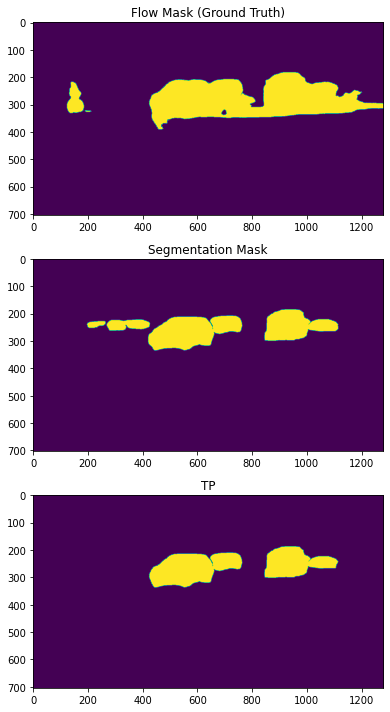

In [38]:
#View true postives


#create a frame using detectron2 output
detectron_mask = detectron_combined_frames[to_compare]
#create a frame using the FlowNet output
flow_mask = flow_to_mask(flow_file_list[to_compare])[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))

axs[0].set_title('Flow Mask (Ground Truth)')
axs[0].imshow(flow_mask)

axs[1].set_title('Segmentation Mask')
axs[1].imshow(detectron_mask)

axs[2].set_title('TP')
axs[2].imshow(flow_mask & detectron_mask)

fig. tight_layout()
plt.show()

The output of the TP for a given frame look pretty good. The objects are cleaner and there are less occurances of artifact object as each frame is checked. A downside of this approch is that Detectron2 identifies all objects while the FlowNet mask only contains moving objects. So this approach will effectively cancel out all non-moving objects. This is okay for this application of trying to improve the ability of Detectron2 to have more consistencey frame-to-frame

#### False Positives (FP)

Effectively segmentation layer - ground-truth layer. This tells us the area where Detectron2 detects an object, and where FlowNet does not detect a moving object.
Let's visualize a FP.

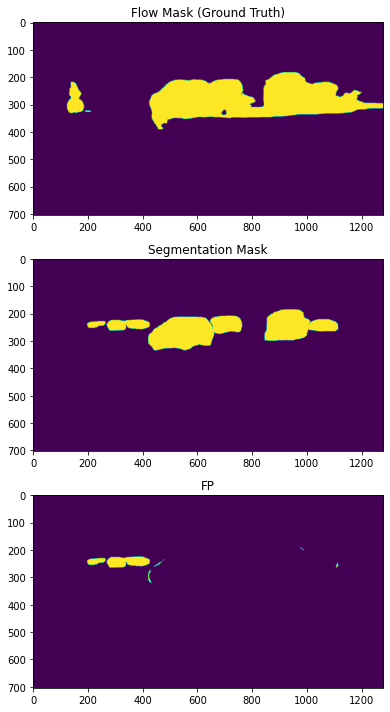

In [39]:
#View false positives


#create a frame using detectron2 output
detectron_mask = detectron_combined_frames[to_compare]
#create a frame using the FlowNet output
flow_mask = flow_to_mask(flow_file_list[to_compare])[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))

axs[0].set_title('Flow Mask (Ground Truth)')
axs[0].imshow(flow_mask)

axs[1].set_title('Segmentation Mask')
axs[1].imshow(detectron_mask)

zeros = np.zeros((height, width), dtype=int)
tp = zeros + detectron_mask.astype(np.int)
tp = tp - flow_mask.astype(np.int)
axs[2].set_title('FP')
axs[2].imshow(tp>0)

fig.tight_layout()
plt.show()

In [40]:
print(dice_loss(seg_frames_tensor,flow_frames_tensor))

(tensor(0.7306, device='cuda:0'), {'acc_0': 0.9384410381317139, 'recall_0': 0.5012502074241638, 'prec_0': 0.8779165744781494, 'f1_0': 0.6381474137306213, 'dice_0': 0.5314122438430786, 'acc_1': 0.9387540221214294, 'recall_1': 0.5021955966949463, 'prec_1': 0.9025148749351501, 'f1_1': 0.645313024520874, 'dice_1': 0.5236441493034363, 'acc_2': 0.9439974427223206, 'recall_2': 0.5412324070930481, 'prec_2': 0.9026182889938354, 'f1_2': 0.676699161529541, 'dice_2': 0.48862791061401367, 'acc_3': 0.9333451986312866, 'recall_3': 0.5125793814659119, 'prec_3': 0.8804817199707031, 'f1_3': 0.647949755191803, 'dice_3': 0.5207650661468506, 'acc_4': 0.925122082233429, 'recall_4': 0.4911833703517914, 'prec_4': 0.8965580463409424, 'f1_4': 0.634663462638855, 'dice_4': 0.5351596474647522, 'acc_5': 0.9432572722434998, 'recall_5': 0.6019918918609619, 'prec_5': 0.8853888511657715, 'f1_5': 0.7166919708251953, 'dice_5': 0.44152772426605225, 'acc_6': 0.9315341114997864, 'recall_6': 0.5399836301803589, 'prec_6': 0.8

## 2.?? - An alternative and more simple method of combining the output from Detectron2 and FlowNet

Another method prosed that would combine the output of Detectron2 and FlowNet would be to simple take a logical AND of both output masks and make that into an output video.

Essentially this would only show any pixels that were both idientified by Detectron2 and also determined to be moving by using the theshold method on FlowNet2, and therefor would be present in the respective masks.

To illustrate this approach, we will create one frame of each mask and then combine them.

Change ```to_compare``` to different frames from 0-30 to see how each frame compares. For example, frame pair ```0``` matches pretty well, but ```12``` does not.

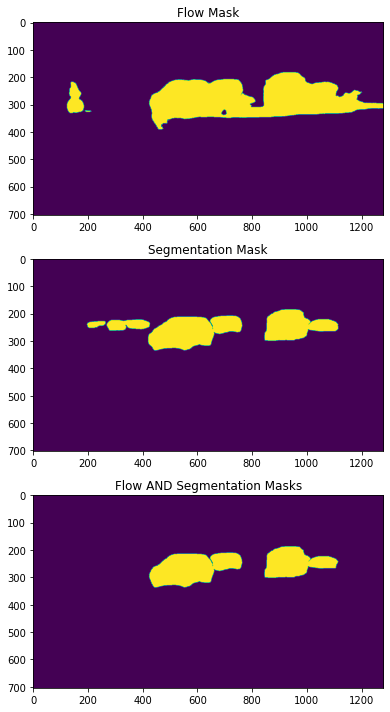

In [41]:
to_compare = 0
#create a frame using detectron2 output
detectron_mask = detectron_combined_frames[to_compare]
flow_mask = flow_to_mask(flow_file_list[to_compare])[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))

axs[0].set_title('Flow Mask')
axs[0].imshow(flow_mask)

axs[1].set_title('Segmentation Mask')
axs[1].imshow(detectron_mask)

axs[2].set_title('Flow AND Segmentation Masks')
axs[2].imshow(np.logical_and(flow_mask, detectron_mask))

fig. tight_layout()
plt.show()

The above figure depicting the the Flow AND segmentation masks shows the union of the two masks. It appears to be a much smoother version of the segmentation mask, with less smaller artifacts.

Lets combine 30 of these AND frames to make a short video clip to observe.

100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


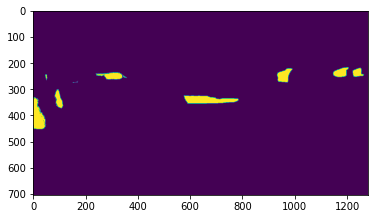

In [42]:
out_name = "and_mask.mp4"
#make the frames and save them
for a in tqdm.trange(len(flow_file_list)):
    name = "and_mask_"+str(a)+".png"
    plt.imshow(detectron_combined_frames[a] & flow_to_mask(flow_file_list[a])[2])
    plt.savefig(name)

#create the output video with ffmpeg
out = sp.run(["ffmpeg", "-y", "-i", "and_mask_%d.png", "-vcodec", "mpeg4", out_name])

#delete the temp .png files
fileList = glob.glob('and_mask_*.png')
#Iterate over the list of filepaths & remove each file.
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

Once again, if the video does not play below, it can be found in the directory engg3130-project/, downloaded, and viewed locally.

In [43]:
Video('and_mask.mp4', embed=True)

While this is a very simple approach it is not neccesarily the best approach. The video is certainly smoother, but not complete. For some frames there appears to be an apparent issue with frame masks lining up nicely, and as such, not all of the objects in the video are represented completely.

Rather than being a way to improve consistency between frames, this technique is more useful at a neat way to visualize both sets of data.

## 3 - Limitations of Approach

One limitation of using flownet2-pytorch to generate movement masks is when the input video file has a "background". Consider for example, the following video:

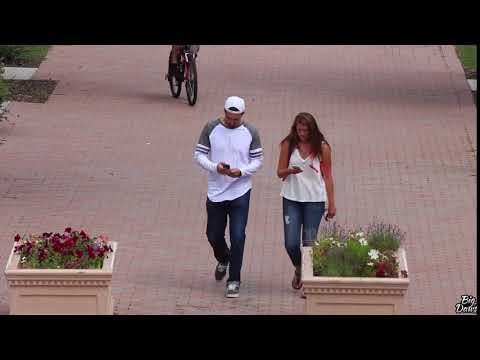

In [44]:
YouTubeVideo("wZVu6g4U77Q")

This video is differnent from the initial ```driveby.mp4``` video used. Namely, the camera is panning down to follow the people as they walk. From the frame of reference of the camera, it appears as the background (the walkway in the case) is moving upwards. This is considered "motion" and will be detectd by flownet2.

To investigate the effects of this movement, lets look at a visualized frame of flownet data from this video and compare it to a frame from our driving video:

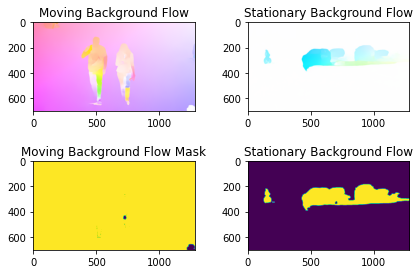

In [45]:
flow_folder = "./flow_data/driveby/"
flow_file = "000000.flo"
path1 = flow_folder+flow_file

flow_folder = "./flow_data/walking/"
flow_file = "000000.flo"
path2 = flow_folder+flow_file

fig, axs = plt.subplots(2,2)
path_to_image = "./flow_data/walking/images/"
image = flow_file+".png"
img1 = plt.imread(path_to_image+image)

path_to_image = "./flow_data/driveby/images/"
image = flow_file+".png"
img2 = plt.imread(path_to_image+image)

axs[0,0].set_title('Moving Background Flow')
axs[0,0].imshow(img1)
axs[0,1].set_title('Stationary Background Flow')
axs[0,1].imshow(img2)
axs[1,0].set_title('Moving Background Flow Mask')
axs[1,0].imshow(flow_to_mask(path2)[2])
axs[1,1].set_title('Stationary Background Flow')
axs[1,1].imshow(flow_to_mask(path1)[2])

fig. tight_layout()
plt.show()

As is made very evident above, when the background is not stationary, it becomes very hard to discretize moving from non-moving parts of the frame using the pixel-magnitude approach. 

However, what this is useful for is in an automatic classifier to determine if the camera is moving for a given video. In these cases, we would notice something similar to the moving background flow mask, above. We would notice most of the video showing a pixel movement magnitude of greater than threshold.